Check out:
    
1. TorchVison:https://pytorch.org/vision/stable/index.html
2. TorchAudio: https://pytorch.org/audio/stable/index.html
3. TorchText: https://pytorch.org/text/stable/index.html

In [72]:
# Torch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchinfo import summary
import torchvision

# Images
from PIL import Image
import matplotlib.pyplot as plt

# Misc
import requests
import zipfile
from pathlib import Path
import os
import random
import numpy as np
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer
import pandas as pd

torch.__version__

'1.12.1+cu102'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# !nvidia-smi

## 1. Get Data


The dataset below is a subset of the Food101 dataset from torchvision datasets.

In [4]:
# Set up path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exist..skipping download")
else:
    print(f"{image_path} does not exist, creating one..")
    image_path.mkdir(parents=True, exist_ok=True)    

data/pizza_steak_sushi directory already exist..skipping download


In [5]:
# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    # Remember to copy the 'raw' link for data!
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    request = requests.get(url)
    print(f"Downloading data..")
    f.write(request.content)

In [6]:
# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data..")
    zip_ref.extractall(image_path)

Unzipping data..


## 2. Data preparation and data exploration

In [7]:
def walk_through_dir(dir_path):
    """Walks through directory and returns it's contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.


In [9]:
# Setup training and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualising the images


1. Get all image paths
2. Pick random image path using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open image with `PIL`
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/1105700.jpg
Image class: pizza
Image height: 512
Image width: 512


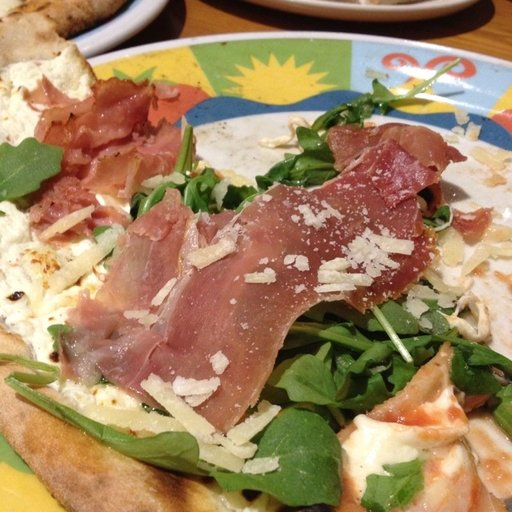

In [10]:
# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg')) # first *: test/train, second: pizza/steak/sushi, third: any image

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

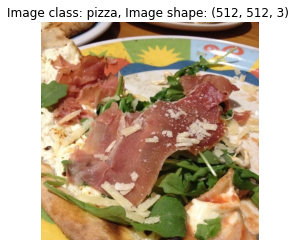

In [11]:
# Try to visualise with matplotlib

img_as_array = np.asarray(img)
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}, Image shape: {img_as_array.shape} ")
plt.axis(False)
plt.show()

In [12]:
img_as_array

array([[[242, 224, 188],
        [241, 223, 187],
        [240, 221, 188],
        ...,
        [ 83,  24,   0],
        [ 75,  18,   0],
        [ 70,  13,   0]],

       [[243, 225, 189],
        [242, 224, 188],
        [240, 221, 188],
        ...,
        [103,  44,  12],
        [ 92,  33,   3],
        [ 82,  25,   0]],

       [[242, 224, 188],
        [241, 223, 187],
        [237, 221, 187],
        ...,
        [121,  62,  30],
        [110,  51,  19],
        [103,  44,  12]],

       ...,

       [[246, 210,  90],
        [246, 210,  90],
        [245, 208,  91],
        ...,
        [115,  97,  87],
        [117, 103, 100],
        [109,  99,  98]],

       [[245, 209,  87],
        [245, 209,  87],
        [246, 210,  90],
        ...,
        [105,  85,  74],
        [105,  90,  85],
        [105,  94,  92]],

       [[245, 209,  87],
        [246, 210,  88],
        [247, 211,  91],
        ...,
        [110,  90,  79],
        [108,  93,  88],
        [110,  99,  97]]

## 3. Transforming data

Before we can use images with PyTorch, we have to:
1. Turn them into tensors
2. Turn it into a `torch.utils.data.Dataset` and then a `torch.utils.data.DataLoader`.

### 3.1 Transforming data with torchvision.transforms

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip images on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img)

tensor([[[0.5059, 0.5020, 0.2431,  ..., 0.7098, 0.8745, 0.9216],
         [0.5451, 0.5020, 0.2353,  ..., 0.6941, 0.7490, 0.8902],
         [0.5647, 0.5529, 0.4000,  ..., 0.8078, 0.8000, 0.8314],
         ...,
         [0.8431, 0.8510, 0.8118,  ..., 0.9608, 0.9725, 0.9686],
         [0.6196, 0.7333, 0.7412,  ..., 0.9608, 0.9608, 0.9608],
         [0.5216, 0.7176, 0.7725,  ..., 0.9608, 0.9569, 0.9608]],

        [[0.2588, 0.2667, 0.1216,  ..., 0.5412, 0.7765, 0.8549],
         [0.2902, 0.2706, 0.1098,  ..., 0.4824, 0.5882, 0.7922],
         [0.3176, 0.3137, 0.2157,  ..., 0.6471, 0.6275, 0.6784],
         ...,
         [0.6431, 0.6627, 0.6235,  ..., 0.8078, 0.8196, 0.8157],
         [0.4627, 0.5412, 0.5294,  ..., 0.8118, 0.8157, 0.8118],
         [0.3882, 0.4941, 0.5569,  ..., 0.8078, 0.8078, 0.8157]],

        [[0.1020, 0.1098, 0.0627,  ..., 0.3569, 0.6118, 0.7176],
         [0.1098, 0.1098, 0.0549,  ..., 0.2745, 0.4000, 0.6431],
         [0.1176, 0.1098, 0.0863,  ..., 0.4667, 0.4510, 0.

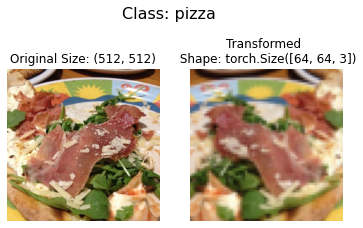

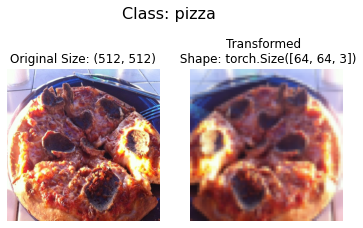

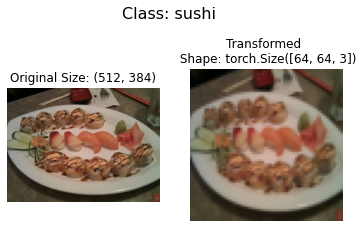

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images from a path list of images and 
    loads/transforms them. Then plots original vs transformed
    """
    if seed: 
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # change the shape for matplot, the position of colour channels is diff in numpy and tensor
            # ie, (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Shape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                        transform=data_transform,
                        n=3,
                        seed=42)            

## 4. Option 1: Load images using 
## `torch.vision.datasets.ImageFolder`

In [16]:
# Use ImageFolder to create datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for data
                                  target_transform=None # transform for labels
                                 )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [18]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image type: {img.dtype}")
print(f"Image label: {label}")
print(f"Image label type: {type(label)}")
print(f"Label name: {class_names[label]}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [colour_channels, height, width]
Original shape: torch.Size([64, 64, 3]) -> [height, width, colour_channels]


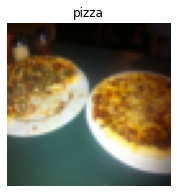

In [21]:
# Rearrage the order of dimensions of img
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [colour_channels, height, width]")
print(f"Original shape: {img_permute.shape} -> [height, width, colour_channels]")

# Plot the image
plt.figure(figsize=(4,3))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label])
plt.show()

### 4.1 Turn loaded images into `DataLoader`

In [22]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # IMPORTANT!! 
                              shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)  

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb32c1ff790>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb32c1ff910>)

In [23]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [24]:
len(train_data), len(test_data)

(225, 75)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, colour_channels, height, width]")
print(f"Image labels shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, colour_channels, height, width]
Image labels shape: torch.Size([32])


## 5. Option 2: Loading images with a custom  `torch.utils.data.Dataset`

Pros: 
- Can create a dataset for any data at hand
- Not limited to PyTorch pre-built functions

Cons:
- More code and could be prone to errors or performance issues


All custom datasets in PyTorch subclass `torch.utils.data.Dataset`

In [26]:
# Instance of torchvision.datasets.ImageFolder()
# to see what we want to replicate
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [27]:
test_dir, train_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

### 5.1 Creating a helper function to get class_names


1. `os.scandir()` is used to traverse target directories
2. Raise error if class_names are not found
3. Turn class_names into a dict and a list and return them

In [28]:
# Setup path for target director
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from target_directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory
    """
    
    # 1. Get the class names by scanning the target directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
    
    # 2. Raise an error if class names couldn't be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    # 3. Create a dict of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [30]:
find_classes(train_dir), find_classes(test_dir)

((['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}),
 (['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}))

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory and a transform 
3. Create attributes like: 
    - paths: paths of images
    - transform: transform to be used
    - classes: a list of target classes
    - class_to_idx: a dict of target classes mapped to integer labels
4. Create a function to load images
5. Overwrite `__len__()` method to return the length of the dataset
6. Overwrite `__getitem__()` method to return a given sample when the index is passed

In [31]:
# Write a custom dataset class

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialise our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        
        # 3. Create class attributes
        
        # Get all the image paths
        self.targ_dir = targ_dir
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        
        # Setup transforms
        self.transform = transform
        self.find_classes()
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = self.find_classes()

    def find_classes(self) -> Tuple[List[str], Dict[str, int]]:
        """
        Finds the class folder names in a target directory
        """

        # 1. Get the class names by scanning the target directory
        classes = sorted([entry.name for entry in os.scandir(self.targ_dir) if entry.is_dir()])

        # 2. Raise an error if class names couldn't be found
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {self.targ_dir}")
            
        # 3. Create a dict of index labels
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
        return classes, class_to_idx
        
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image via a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """
        Returns the total number of samples 
        """
        return len(self.paths)

    # 6. Overwrite __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns a particular sample and it's label: (X, y)
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Tranform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx

In [32]:
# Create a transform 
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fb32c2ad430>,
 <__main__.ImageFolderCustom at 0x7fb32c2ad310>)

In [34]:
len(train_data_custom), len(train_data)

(225, 225)

In [35]:
len(test_data_custom), len(test_data)

(75, 75)

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
# Check for equality between original
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in `Dataset`, class_names, number of images to visualise, etc
2. Cap max no. of images to 10
3. Set the random seed for reproducibility
4. Get list of random sample indices from tagert dataset
5. Set up matplotlib plot
6. loop thrpugh images and plot
7. Make sure dim of images mtch up with matplotlib

In [39]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"Images should be less than 10, that's what I'll be doing now")
     
    # 3. Set the seed
    if seed:
        random.seed(seed)
        
    # 4. Get random sample indices
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup plot
    plt.figure(figsize=(16,8))
    
    # 6. Loop thru random indices and plot
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) 

        # Plot adjusted samples 
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title+f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

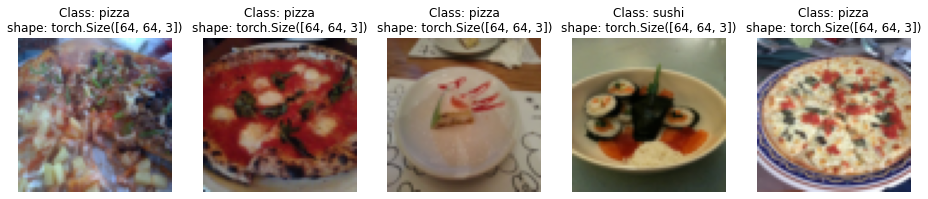

In [40]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

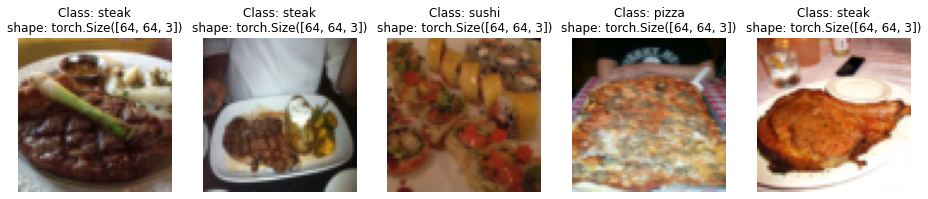

In [41]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data_custom, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### 5.4 Dataloader for custom Dataset

In [42]:
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(train_data_custom, 
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(train_data_custom, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

In [43]:
img_custom, label_custom = next(iter(test_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms: Data Augmentation

- Rotate
- Shear
- Cropping
- Flipping
- ...

In [44]:
train_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor()])

In [45]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/244505.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2821048.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1899785.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/393658.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1008844.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2330965.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/715169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2811032.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2992084.jpg')]

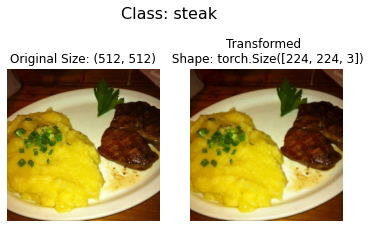

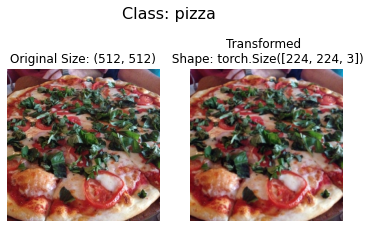

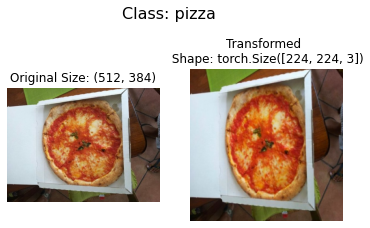

In [46]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Load Data

In [47]:
# Create a simple transform 
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Load data using datasets.ImageFolder
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn datasets into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

### 7.2 Model

In [48]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [49]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass pm a single image (to test the model)

In [50]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9130e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4965e-03],
        [ 1.9974e-02, -3.2689e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### `torchinfo` to get model summary

In [52]:
summary(model_0, 
        input_size=[1, 3, 64, 64] # Batch of a single image
       )

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Training and testing Model 0 

In [53]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through the data loader in batches
    for batch, (X, y) in enumerate(dataloader):
        
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimiser zero grad
        optimiser.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimiser step 
        optimiser.step()
        
        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [54]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
    # Put model in eval mode
    model.eval()
    
    # Setup test_loss and test_accuracy 
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            
            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)
            
        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [55]:
# Combining train_step() and test_step()

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimiser: torch.optim.Optimizer,
          epochs: int=5,
          device=device
          ):
    
    # Create an empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop thru training and testing steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimiser=optimiser,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # Print out progress
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train_acc: {train_acc: .4f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc: .4f}% " )
        
        # 5. Update result dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

### 7.7 Train and eval model 0

In [56]:
print(device)

cuda


In [57]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set no. of epochs and LR
EPOCHS = 5
LR = 0.001

# Instance of model
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(params=model_0.parameters(),
                             lr=LR)

# Set timer
start_time = timer()
# Train model 
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimiser=optimiser,
                        epochs=EPOCHS,
                        device=device)
# End timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.2f}s")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train_acc:  0.3047% | Test loss: 1.0983 | Test acc:  0.3011% 
Epoch: 1 | Train loss: 1.0998 | Train_acc:  0.3281% | Test loss: 1.0697 | Test acc:  0.5417% 
Epoch: 2 | Train loss: 1.0869 | Train_acc:  0.4883% | Test loss: 1.0807 | Test acc:  0.4924% 
Epoch: 3 | Train loss: 1.0846 | Train_acc:  0.4023% | Test loss: 1.0606 | Test acc:  0.5833% 
Epoch: 4 | Train loss: 1.0663 | Train_acc:  0.4180% | Test loss: 1.0661 | Test acc:  0.5644% 
Total training time: 4.28s


In [58]:
model_0_results

{'train_loss': [1.1063192039728165,
  1.0997920036315918,
  1.0868775248527527,
  1.0846316814422607,
  1.0663445889949799],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41796875],
 'test_loss': [1.0983233054478962,
  1.0697267055511475,
  1.0807392994562786,
  1.0606040159861247,
  1.0660843054453533],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

In [59]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [60]:
model_0_results["test_loss"]

[1.0983233054478962,
 1.0697267055511475,
 1.0807392994562786,
 1.0606040159861247,
 1.0660843054453533]

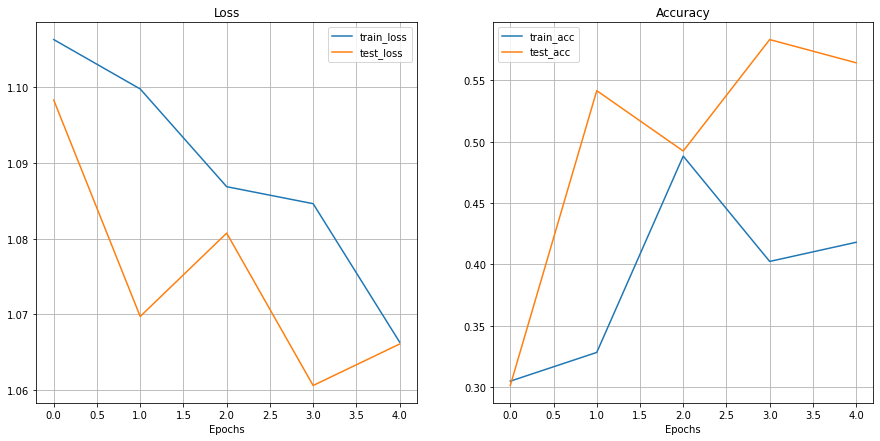

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plots training curves of a results dictionary
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    acc = results["train_acc"]
    test_acc = results["test_acc"]
    
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()
    
plot_loss_curves(model_0_results)

## 8. Ideal loss curve

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

## 9. Model 1: TinyVGG with Data Augmentation

In [62]:
# Create training transform 
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2. Create a train and test `Dataset` and `Dataloader`

In [63]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [64]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

### 9.3 Construct and train `model_1`

In [65]:
model_1 = TinyVGG(input_shape=3,
                  output_shape=len(class_names),
                  hidden_units=10)

model_1.to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [66]:
summary(model_1)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      5,073
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0

In [67]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epochs
NUM_EPOCHS = 5

# loss function
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# start the timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimiser=optimiser,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total train time {end_time-start_time: .3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1045 | Train_acc:  0.2500% | Test loss: 1.1016 | Test acc:  0.2604% 
Epoch: 1 | Train loss: 1.0760 | Train_acc:  0.4258% | Test loss: 1.1316 | Test acc:  0.2604% 
Epoch: 2 | Train loss: 1.0731 | Train_acc:  0.4258% | Test loss: 1.1705 | Test acc:  0.2604% 
Epoch: 3 | Train loss: 1.1230 | Train_acc:  0.3047% | Test loss: 1.1542 | Test acc:  0.2604% 
Epoch: 4 | Train loss: 1.0730 | Train_acc:  0.4609% | Test loss: 1.1491 | Test acc:  0.2917% 
Total train time  4.282 seconds.


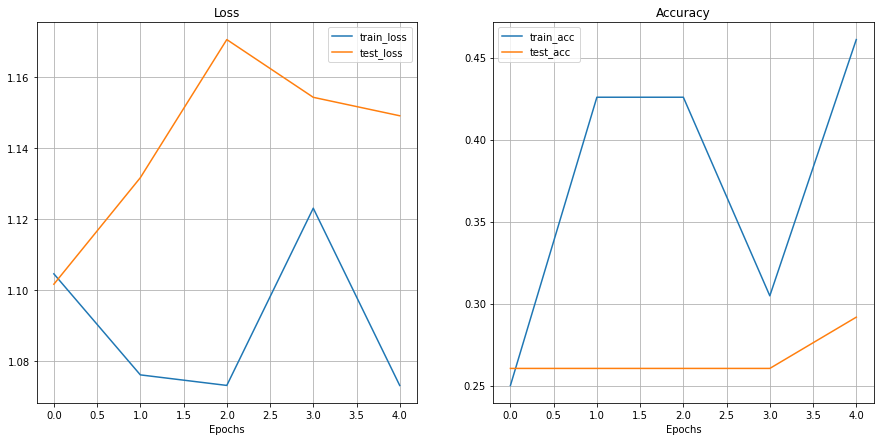

In [68]:
plot_loss_curves(model_1_results)

## 10. Compare model results 

1. Hardcoding
2. TensorBoard: https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases: https://wandb.ai/site
4. ML Flow: https://mlflow.org/

In [69]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098323,0.301136
1,1.099792,0.328125,1.069727,0.541667
2,1.086878,0.488281,1.080739,0.492424
3,1.084632,0.402344,1.060604,0.583333
4,1.066345,0.417969,1.066084,0.564394


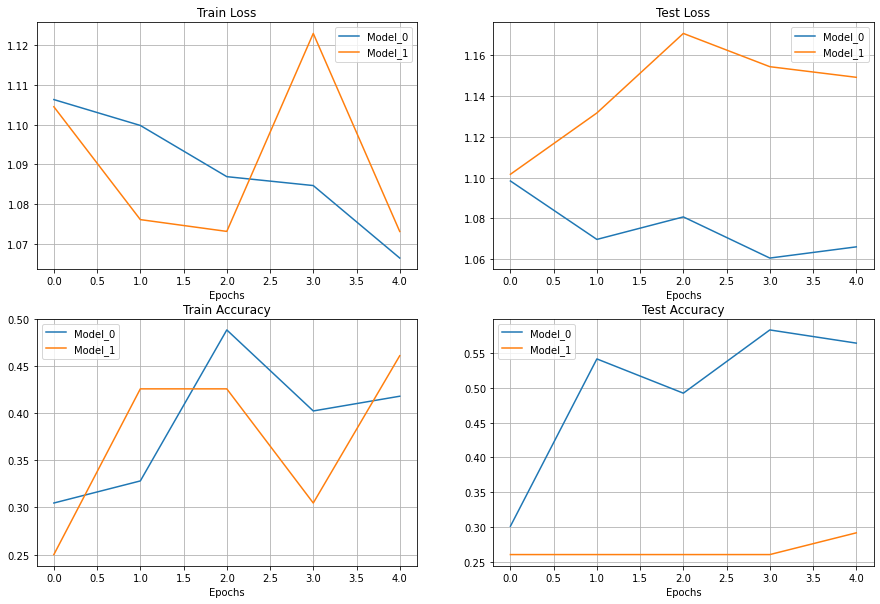

In [70]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.grid()

## 11. Making a prediction on a custom image

In [81]:
CUSTOM_IMG_PATH = data_path / "04-pizza-dad.jpeg"

# Download if it doesnt exist
if not CUSTOM_IMG_PATH.is_file():
    with open(CUSTOM_IMG_PATH, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print("Downloading..")
        f.write(request.content)
else:
    print("Already exist, skipping...")

Already exist, skipping...


### 11.1 Loading a custom image with PyTorch

- Tensor form with datatype: torch.float32
- Shape: 64x64x3
- Device?

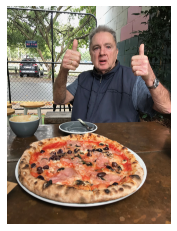

In [86]:
custom_image_uint8 = torchvision.io.read_image(str(CUSTOM_IMG_PATH))
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [91]:
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")
print(f"Custom image device: {custom_image_uint8.device}")

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dat

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [115]:
# Try to make a prediction on an image in uint8 format, 
# that is the source of error
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

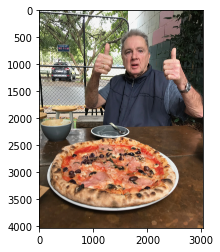

In [104]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(CUSTOM_IMG_PATH)).type(torch.float32) / 255.
plt.imshow(custom_image.permute(1,2,0))

In [114]:
# this will error because image is not resized (transformed)

model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [107]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

In [108]:
custom_image.shape, custom_image_transformed.shape

(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

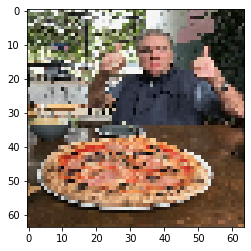

In [112]:
plt.imshow(custom_image_transformed.permute(1,2,0))
plt.show()

In [113]:
# This will error, since the batch size is not defined
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [119]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [121]:
# Adding batchsize

model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
    
custom_image_pred

tensor([[ 0.0460,  0.0593, -0.2155]], device='cuda:0')

-------

**Note:**

------------
To make a prediction on a custom image, we had to:
- Load the image and turn it into a tensor
- Make sure the image was the same datatype as the model (torch.float32)
- Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size (1, 3, 64, 64)
- Make sure the image was on the same device as our model

In [123]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3593, 0.3641, 0.2766]], device='cuda:0')

In [125]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([1], device='cuda:0')

In [126]:
class_names[custom_image_pred_label]

'steak'

### 11.3 Putting custom image prediction together: Building a function

In [135]:
def custom_image_pred(model: torch.nn.Module,
                      image_path: str,
                      class_names: List[str] = None,
                      transform = None,
                      device = device):
    # Load image and convert datatype
    image_og = torchvision.io.read_image(image_path).type(torch.float32)
    
    # Divice the image pixel values by 255. to get them to be 
    # between [0, 1]
    image_og = image_og / 255.
    
    # Transform if necessary
    if transform:
        image = transform(image_og)
    
    # Make sure model is on target device
    model.to(device)
    
    # Turn on eval/inference mode and make a pred
    model.eval()
    with torch.inference_mode():
        
        # Add extra dim for batch size
        image = image.unsqueeze(0)
        
        # Make prediction and make sure the image is on device
        image_pred = model(image.to(device))
        
    # Convert logits to pred prob
    image_pred_prob = torch.softmax(image_pred, dim=1)
    
    # Convert to pred labels
    image_pred_labels = torch.argmax(image_pred_prob, dim=1)
    
    plt.imshow(image_og.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[image_pred_labels.cpu()]} | Prob: {image_pred_prob.max()}"
    else:
        title = f"Pred: {image_pred_labels.cpu()} | Prob: {image_pred_prob.max()}"
        
    plt.title(title)
    plt.axis(False)
    plt.show()

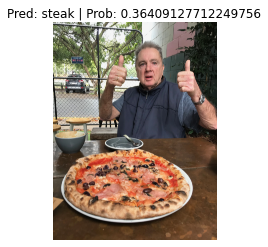

In [136]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_pred(model=model_1,
                  image_path=str(CUSTOM_IMG_PATH),
                  class_names=class_names,
                  transform=custom_image_transform,
                  device=device)